this file mainly plot some demonstrative figures on our HOD.

In [1]:
import numpy as np
import corner
import matplotlib.pyplot as plt
import seaborn as sns
from emcee.backends import HDFBackend
from read_files import *
from run_mcmc import HODParameter

In [2]:
with open('./configs/config_small_step_pow3.yaml', 'r') as f:
# with open('./configs/config_delta.yaml', 'r') as f:
    par_configs, other_configs = list(yaml.load_all(f, yaml.FullLoader))
    # ========== reading configs ==========
    # don't set the lgMmin too large or sig_lgM too small, otherwise N_c will be all zeros
    available_fields = ['Nwalkers', 'Nstep', 'Nburnin', 'Npro', 'auto_range', 'cross_range',
                        'backend_file', 'numpy_file', 'wp_table_path', 'signal_path', 'module_path']
    Nwalkers = 40
    Nstep = 4000
    Nburnin = 300
    Npro = 40
    auto_range = None
    cross_range = None
    backend_file = ''
    numpy_file = ''
    wp_table_path = '../wp_table'
    signal_path = '../signal'
    module_path = './HOD/calc_wp.py'

    for k in available_fields:
        if k in other_configs:
            locals()[k] = other_configs[k]

    wp_table = read_wp(wp_table_path)
    rp_auto, signal_auto, rp_cross, signal_cross = read_signal(signal_path + '/signal.npy')
    cov = read_cov(signal_path + '/cov.npy')
    logM, Nh = read_halo_mass_function('../halo_mass_function.npy')
    module = read_module(module_path)
    chi_2 = module.chi_2
    N_c = module.N_c
    # for better performance I would recommend setting these as global variable
    # ========== apply the fitting range ==========

    if auto_range or cross_range:
        if auto_range is None:
            auto_range = [0, len(rp_auto)]
        if cross_range is None:
            cross_range = [0, len(rp_cross)]
        l_a, r_a = auto_range[0], auto_range[1]
        l_c, r_c = cross_range[0], cross_range[1]

        auto_size = len(rp_auto)
        cross_size = len(rp_cross)
        rp_auto = rp_auto[l_a:r_a]
        rp_cross = rp_cross[l_c:r_c]
        signal_auto = signal_auto[l_a:r_a]
        signal_cross = signal_cross[l_c:r_c]

        cov = np.vstack((
            np.hstack((cov[l_c:r_c, l_c:r_c], cov[l_c:r_c, cross_size+l_a:cross_size+r_a])),
            np.hstack((cov[cross_size+l_a:cross_size+r_a, l_c:r_c], cov[cross_size+l_a:cross_size+r_a, cross_size+l_a:cross_size+r_a]))
        ))

    signal = np.hstack((signal_cross, signal_auto))
    cov_inv = np.linalg.inv(cov)

    # ========== handle interpolating table ==========
    wp_table_auto = interpolate_table(wp_table, rp_auto)
    wp_table_cross = interpolate_table(wp_table, rp_cross)

    parameter = HODParameter.from_config(par_configs)
    dof = len(signal) - parameter.ndim - np.isnan(signal).sum()
    print(parameter)
    print('dof = {}'.format(dof))
    print(dof + np.sqrt(2*dof)*1.96)

HODParameter(lgMmin:    14  [10~17]
             sig_lgM:   0.5 [0.001~1]
             Amp:       1   [fixed]
             lgM0:      12  [11~16]
             lgM1p:     12  [10.5~16]
             alpha:     1   [0~5])
dof = 29
43.92691528749326


In [3]:
if not numpy_file.endswith('.npy'):
    numpy_file += '.npy'
result = np.load(numpy_file)
array_2d = result.view((np.float64, len(result.dtype.names)))
backend = HDFBackend(backend_file, read_only=True)
chain = backend.get_chain(flat=True, discard=5000)
chi2 = -backend.get_log_prob(flat=True, discard=5000)*2
blobs = backend.get_blobs(discard=5000, flat=True)

print('chi^2 = {}'.format(chi2.mean()))

chi^2 = 40.60289221407896


In [4]:
par = parameter.full_parameters(np.percentile(array_2d, 50, axis=0))
predict = module.w_p(logM, Nh, par, wp_table_auto, wp_table_cross)

In [5]:
nh = Nh
Nc = module.N_c(logM, par)
Ns = Nc * module.N_s_to_N_c(logM, par)
ng = np.sum(nh*(Nc + Ns))
# wp1h = module.w_p_1h(nh, Nc, Ns, ng, wp_table_auto['1h_cs'], wp_table_auto['1h_ss'])

cs1h = np.einsum('i,ij', nh/(ng*ng)*Nc*Ns, wp_table_auto['1h_cs'])

# ss1h = np.einsum('i,ij', nh/(ng*ng)*Ns*(Ns-1), wp_table_auto['1h_ss'])      # assmuing Poisson distribution for Ns
ss1h = np.einsum('i,ij', nh/(ng*ng)*Ns*Ns, wp_table_auto['1h_ss'])

wp1h = cs1h + ss1h

cc2h = np.einsum('i, j, ijk', nh*Nc, nh*Nc, wp_table_auto['2h_cc'])/ng**2
cs2h = 2*np.einsum('i,j,ijk', nh*Nc, nh*Ns, wp_table_auto['2h_cs'])/ng**2
ss2h = np.einsum('i,j,ijk', nh*Ns, nh*Ns, wp_table_auto['2h_ss'])/ng**2

wp2h = cc2h + cs2h + ss2h
# wp2h = module.w_p_2h(nh, Nc, Ns, ng, wp_table_auto['2h_cc'], wp_table_auto['2h_cs'], wp_table_auto['2h_ss'])
w_p_std = wp1h + wp2h

cm = np.einsum('i,ij', nh/ng*Nc, wp_table_cross['cm'])
sm = np.einsum('i,ij', nh/ng*Ns, wp_table_cross['sm'])
w_p_m = cm + sm

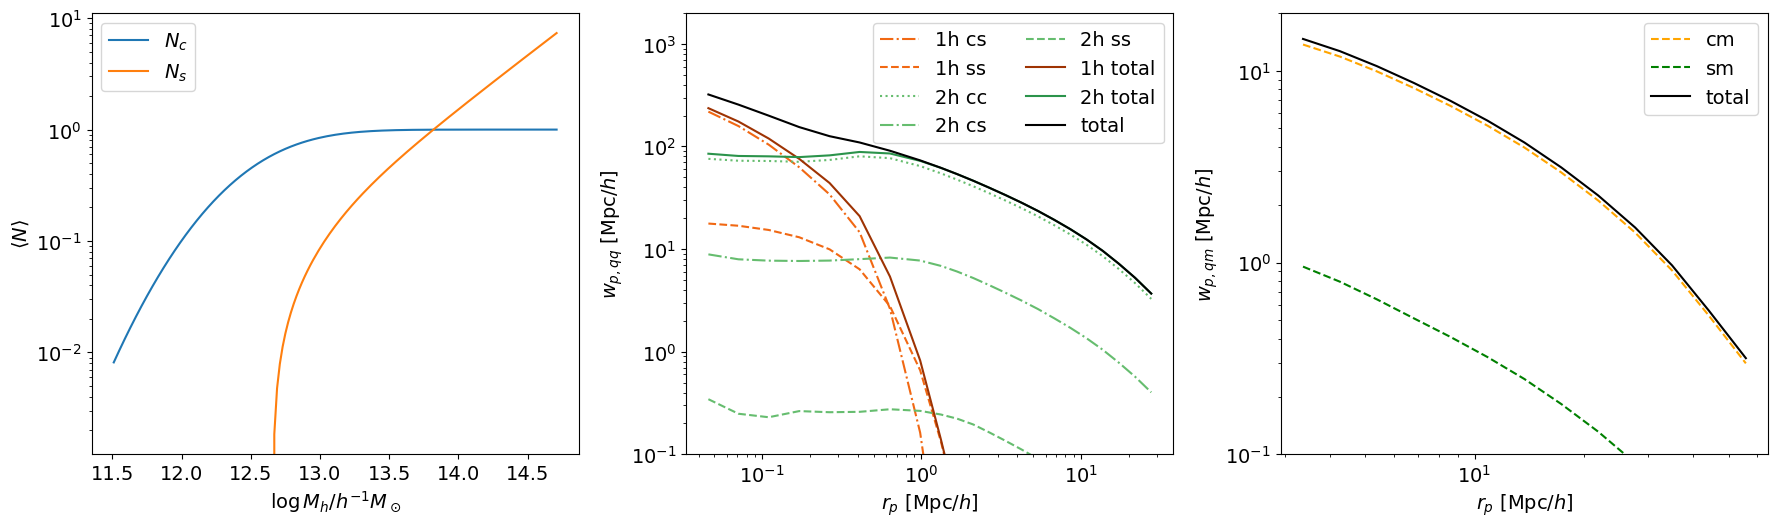

In [14]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 14

cmap_orange = plt.get_cmap('Oranges')
cmap_green = plt.get_cmap('Greens')
color_1h = [cmap_orange(x) for x in np.linspace(0.35, 0.9, 3)]  # cs, ss, total 1h
color_2h = [cmap_green(x) for x in np.linspace(0.35, 0.9, 4)]   # cc, cs, ss, total 2h

fig, axes = plt.subplots(1, 3, figsize=(18, 5.5))

ax = axes[0]
ax.plot(logM, Nc, label=r'$N_c$')
ax.plot(logM, Ns, label=r'$N_s$')
ax.set_xlabel(r'$\log M_h/h^{-1}M_\odot$')
ax.set_ylabel(r'$\langle N\rangle$')
ax.semilogy()
ax.legend()

ax = axes[1]
ax.plot(rp_auto, cs1h, label='1h cs', color=color_1h[1], linestyle='-.')
ax.plot(rp_auto, ss1h, label='1h ss', color=color_1h[1], linestyle='--')

ax.plot(rp_auto, cc2h, label='2h cc', color=color_2h[1], linestyle=':')
ax.plot(rp_auto, cs2h, label='2h cs', color=color_2h[1], linestyle='-.')
ax.plot(rp_auto, ss2h, label='2h ss', color=color_2h[1], linestyle='--')

ax.plot(rp_auto, wp1h, label='1h total', color=color_1h[2])
ax.plot(rp_auto, wp2h, label='2h total', color=color_2h[2])
ax.plot(rp_auto, w_p_std, label='total', color='black', linestyle='-')
ax.legend(loc='upper right', ncol=2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r_p\ [\mathrm{Mpc}/h]$')
ax.set_ylabel(r'$w_{p,qq}\ [\mathrm{Mpc}/h]$')
ax.set_ylim(1e-1, 2e3)

ax = axes[2]
ax.plot(rp_cross, cm, label='cm', color='orange', linestyle='--')
ax.plot(rp_cross, sm, label='sm', color='green', linestyle='--')
ax.plot(rp_cross, w_p_m, label='total', color='black', linestyle='-')
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r_p\ [\mathrm{Mpc}/h]$')
ax.set_ylabel(r'$w_{p,qm}\ [\mathrm{Mpc}/h]$')
ax.set_ylim(1e-1, 2e1)

plt.tight_layout()
plt.savefig('/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/figure/hod_decompose.pdf', bbox_inches='tight')

plt.show()
